## Проект "IT-решение для мониторинга экосистем: Автоматическая система обнаружения лесных пожаров"

Импортируем необходимые библиотеки

In [ ]:
import torch
import kagglehub
import numpy as np
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import random

Загружаем данные с [kaggle](https://www.kaggle.com/datasets/alik05/forest-fire-dataset/data), которые будут использованы в рамках проекта:

Все изображения в наборе данных трёхканальные и имеют разрешение 250 x 250. Изображения были получены путём поиска по различным запросам в нескольких поисковых системах. Каждое изображение содержит только соответствующую область пожара.

Набор данных предназначен для решения бинарной задачи обнаружения пожара и отсутствия пожара в лесном ландшафте. Это сбалансированный набор данных, состоящий из 1900 изображений, по 950 из которых относятся к каждому классу. Набор данных разделён в соотношении 80:20 для обучения и тестирования в предлагаемом исследовании.

A. Khan, B. Hassan, S. Khan, R. Ahmed and A. Adnan, “DeepFire: A Novel Dataset and Deep Transfer Learning Benchmark for Forest Fire Detection,” Mobile Information System, vol. 2022, pp. 5358359, 2022.

In [ ]:
path = kagglehub.dataset_download("alik05/forest-fire-dataset")
print("Путь к файлам датасета:", path)

Using Colab cache for faster access to the 'forest-fire-dataset' dataset.
Путь к файлам датасета: /kaggle/input/forest-fire-dataset


In [ ]:
# Проверим полную структуру датасета
print("Полная структура датасета:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    sub_indent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Покажем только первые 5 файлов в каждой папке
        print(f'{sub_indent}{file}')
    if len(files) > 5:
        print(f'{sub_indent}... и еще {len(files) - 5} файлов')

Полная структура датасета:
forest-fire-dataset/
  Forest Fire Dataset/
    Training/
      nofire/
        nofire_0324.jpg
        nofire_0874.jpg
        nofire_0360.jpg
        nofire_0551.jpg
        nofire_0590.jpg
        ... и еще 755 файлов
      fire/
        fire_0341.jpg
        fire_0946.jpg
        fire_0805.jpg
        fire_0007.jpg
        fire_0577.jpg
        ... и еще 755 файлов
    Testing/
      nofire_0295.jpg
      fire_0234.jpg
      nofire_0372.jpg
      nofire_0555.jpg
      nofire_0246.jpg
      ... и еще 375 файлов


Поскольку мы будем использовать предобученную модель, можно объединить все изображения в тестовый набор данных, что позволит более точно оценить результаты модели.

In [ ]:
all_files = []

def collect_all_images(directory):
    """Собирает все изображения из всех подпапок"""
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    return image_files

all_files = collect_all_images(path)

# Устанавливаем seed для воспроизводимости
random.seed(42)
# Перемешиваем список случайным образом
random.shuffle(all_files)

all_files[:10]

['/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training/nofire/nofire_0136.jpg',
 '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Testing/nofire_0851.jpg',
 '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training/fire/fire_0042.jpg',
 '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training/nofire/nofire_0220.jpg',
 '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training/nofire/nofire_0556.jpg',
 '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training/fire/fire_0035.jpg',
 '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Testing/fire_0335.jpg',
 '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training/fire/fire_0226.jpg',
 '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training/nofire/nofire_0381.jpg',
 '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training/nofire/nofire_0056.jpg']

Визулизируем несколько изображекний, чтобы понимать какие данные мы будем передавать модели на вход.

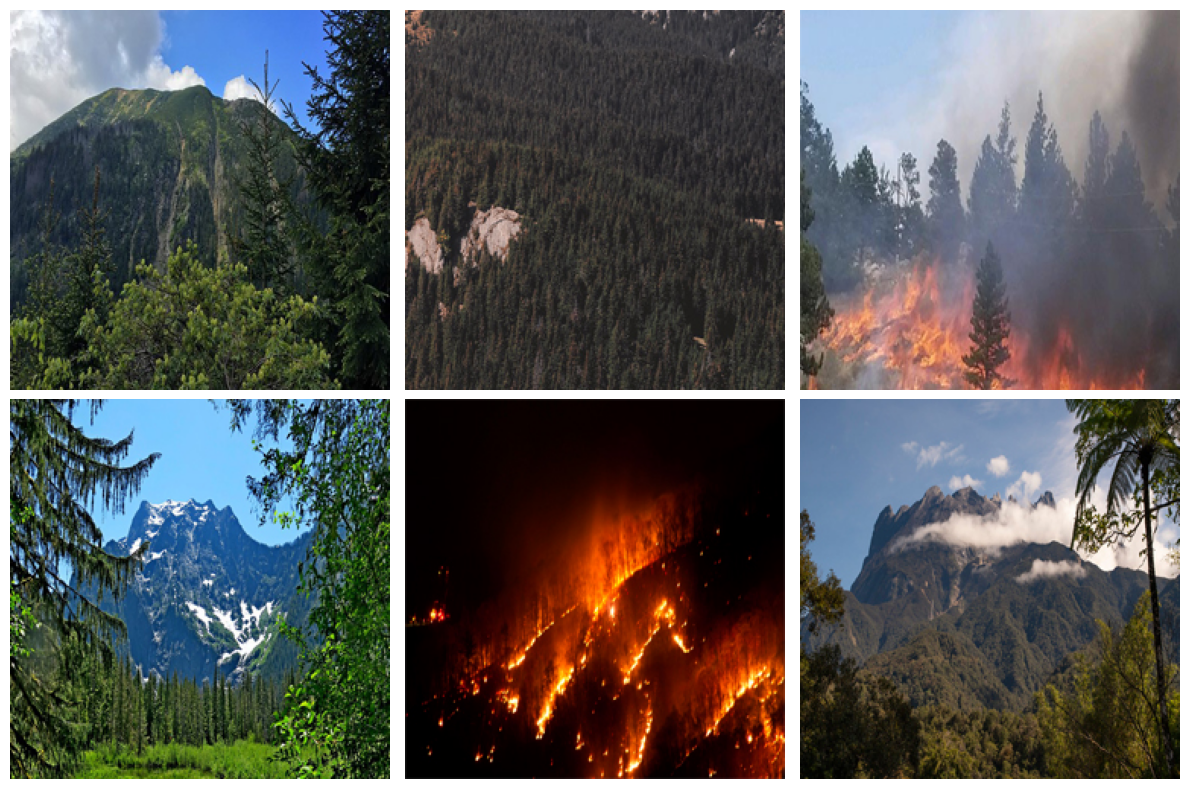

In [ ]:
# Выберем 6 случайных изображений
random_files = random.sample(all_files, min(6, len(all_files)))

# Создадим график
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for idx, filename in enumerate(random_files):
    img_path = os.path.join(path, filename)

    try:
        img = Image.open(img_path)
        row = idx // 3
        col = idx % 3
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
    except:
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Предобученная модель, которая используется в проекте: **[EdBianchi/vit-fire-detection](https://huggingface.co/EdBianchi/vit-fire-detection)**

Эта модель представляет собой дообученную (fine-tuned) версию google/vit-base-patch16-224-in21k для задачи бинарной классификации изображений на наличие или отсутствие огня/пожара.

**Ключевые особенности:**

* Архитектура: Vision Transformer (ViT-Base).

* Задача: Определение признаков пожара на изображениях.

* Входные данные: Изображения, приведенные к разрешению 224x224 пикселей.

* Выходные данные: Вероятность принадлежности к классу "огонь".

* Использоваться в системах раннего обнаружения возгораний по видеопотоку или фото.

In [ ]:
# Загружаем модель и процессор
processor = AutoImageProcessor.from_pretrained("EdBianchi/vit-fire-detection")
model = AutoModelForImageClassification.from_pretrained("EdBianchi/vit-fire-detection")

# Перемещаем модель на GPU если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Переводим в режим оценки
print(f"Модель загружена на: {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Модель загружена на: cuda


In [ ]:
print(f"Архитектура модели: {model.config.model_type}")
print(f"Количество классов: {model.config.num_labels}")
print(f"Размер входного изображения: {model.config.image_size}x{model.config.image_size}")
print(f"Количество каналов: {model.config.num_channels}")
print(f"Размер скрытого слоя: {model.config.hidden_size}")

print("\n Классы модели:")
if hasattr(model.config, 'id2label'):
    for class_id, class_name in model.config.id2label.items():
        print(f"   Класс {class_id}: {class_name}")

Архитектура модели: vit
Количество классов: 3
Размер входного изображения: 224x224
Количество каналов: 3
Размер скрытого слоя: 768

 Классы модели:
   Класс 0: Fire
   Класс 1: Normal
   Класс 2: Smoke


Ниже  приведены две вспомогательные функции для работы с классификацией изображений:

extract_class_from_filename - определяет класс изображения по префиксу имени файла ("fire_" или "nofire_")

predict_single_image - выполняет предсказание класса для одного изображения с помощью модели ViT, возвращая метку класса и вероятности предсказания

In [ ]:
def extract_class_from_filename(filename):
    """
    Определяет класс изображения по имени файла
    """
    if filename.startswith('fire_'):
        return 'Fire'
    elif filename.startswith('nofire_'):
        return 'Normal'


def predict_single_image(image_path, processor, model, device):
    """
    Выполняет предсказание класса для одного изображения.

    Args:
        image_path (str): Путь к файлу изображения
        processor: Предобработчик изображений
        model: Модель классификации
        device: Устройство для вычислений

    Returns:
        dict: Результаты предсказания или None в случае ошибки
    """
    # Загрузка и конвертация изображения
    image = Image.open(image_path).convert("RGB")

    # Предобработка изображения
    inputs = processor(images=image, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Выполнение предсказания (без вычисления градиентов)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Извлечение предсказанного класса
    predicted_class_idx = torch.argmax(logits, dim=-1).item()

    # Вычисление вероятностей с использованием softmax
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Получение метки класса из конфигурации модели
    predicted_label = model.config.id2label[predicted_class_idx]

    return {
        'predicted_class': predicted_class_idx,
        'predicted_label': predicted_label,
        'probabilities': probabilities.cpu().numpy(),
        'confidence': probabilities[predicted_class_idx].item()
    }


Ниже функция demonstrate_model_performance демонстрирует работу модели на небольшой выборке изображений.

1. Выбирает случайные изображения из тестового набора

2. Для каждого изображения получает предсказание модели и сравнивает с истинной меткой

3. Визуализирует результаты в виде сетки изображений с аннотациями

4. Отображает таблицу с детальными результатами

5. Вычисляет и показывает точность модели на демонстрационной выборке

Функция полезна для быстрой качественной оценки работы модели и визуальной проверки её предсказаний.



In [ ]:
def demonstrate_model_performance(test_images, processor, model, device, num_samples=10):
    """
    Демонстрирует работу модели на выборке изображений.

    Args:
        test_images (list): Список путей к тестовым изображениям
        processor: Предобработчик изображений
        model: Модель классификации
        device: Устройство для вычислений
        num_samples (int): Количество изображений для демонстрации

    Returns:
        pd.DataFrame: Результаты демонстрации
    """
    print("" + "=" * 80)
    print("Рассмотрим работу модели на маленькой выборке")
    print("=" * 80)

    # Выбор случайных изображений для демонстрации
    random.seed(42)
    demo_samples = random.sample(test_images, min(num_samples, len(test_images)))

    results = []

    # Создание графического представления
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for idx, image_path in enumerate(demo_samples):
        # Получение предсказания
        prediction = predict_single_image(image_path, processor, model, device)

        if prediction:
            # Извлечение истинной метки из имени файла
            filename = os.path.basename(image_path)
            true_label = extract_class_from_filename(filename)
            if true_label:
                # Сохранение результатов
                results.append({
                    'filename': filename,
                    'true_label': true_label,
                    'predicted_label': prediction['predicted_label'],
                    'confidence': prediction['confidence'],
                    'is_correct': true_label == prediction['predicted_label']
                })

                # Визуализация результата
                row = idx // 5
                col = idx % 5
                image = Image.open(image_path)
                axes[row, col].imshow(image)

                # Определение цвета заголовка
                title_color = 'green' if true_label == prediction['predicted_label'] else 'red'

                axes[row, col].set_title(
                    f"Истинный: {true_label}\nПредсказанный: {prediction['predicted_label']}\nУверенность: {prediction['confidence']:.1%}",
                    color=title_color,
                    fontsize=9
                )
                axes[row, col].axis('off')
            else:
                axes[idx // 5, idx % 5].text(0.5, 0.5, 'Неизвестный класс', ha='center', va='center')
                axes[idx // 5, idx % 5].axis('off')
        else:
            axes[idx // 5, idx % 5].text(0.5, 0.5, 'Ошибка обработки', ha='center', va='center')
            axes[idx // 5, idx % 5].axis('off')

    plt.tight_layout()
    plt.show()

    # Создание DataFrame с результатами
    if results:
        results_df = pd.DataFrame(results)

        print("\n Результаты демонстрационной выборки:")
        print("-" * 70)
        print(results_df[['filename', 'true_label', 'predicted_label',
                         'confidence', 'is_correct']].to_string(index=False))

        # Расчет точности на демонстрационной выборке
        demo_accuracy = results_df['is_correct'].mean()
        correct_count = results_df['is_correct'].sum()
        total_count = len(results_df)

        print(f"\nТочность на демонстрационной выборке: {demo_accuracy:.2%} "
              f"({correct_count}/{total_count})")

        return results_df

    return pd.DataFrame()

Обучающих изображений: 1520
Тестовых изображений: 380
Всего изображений: 1900

Рассмотрим работу модели на маленькой выборке


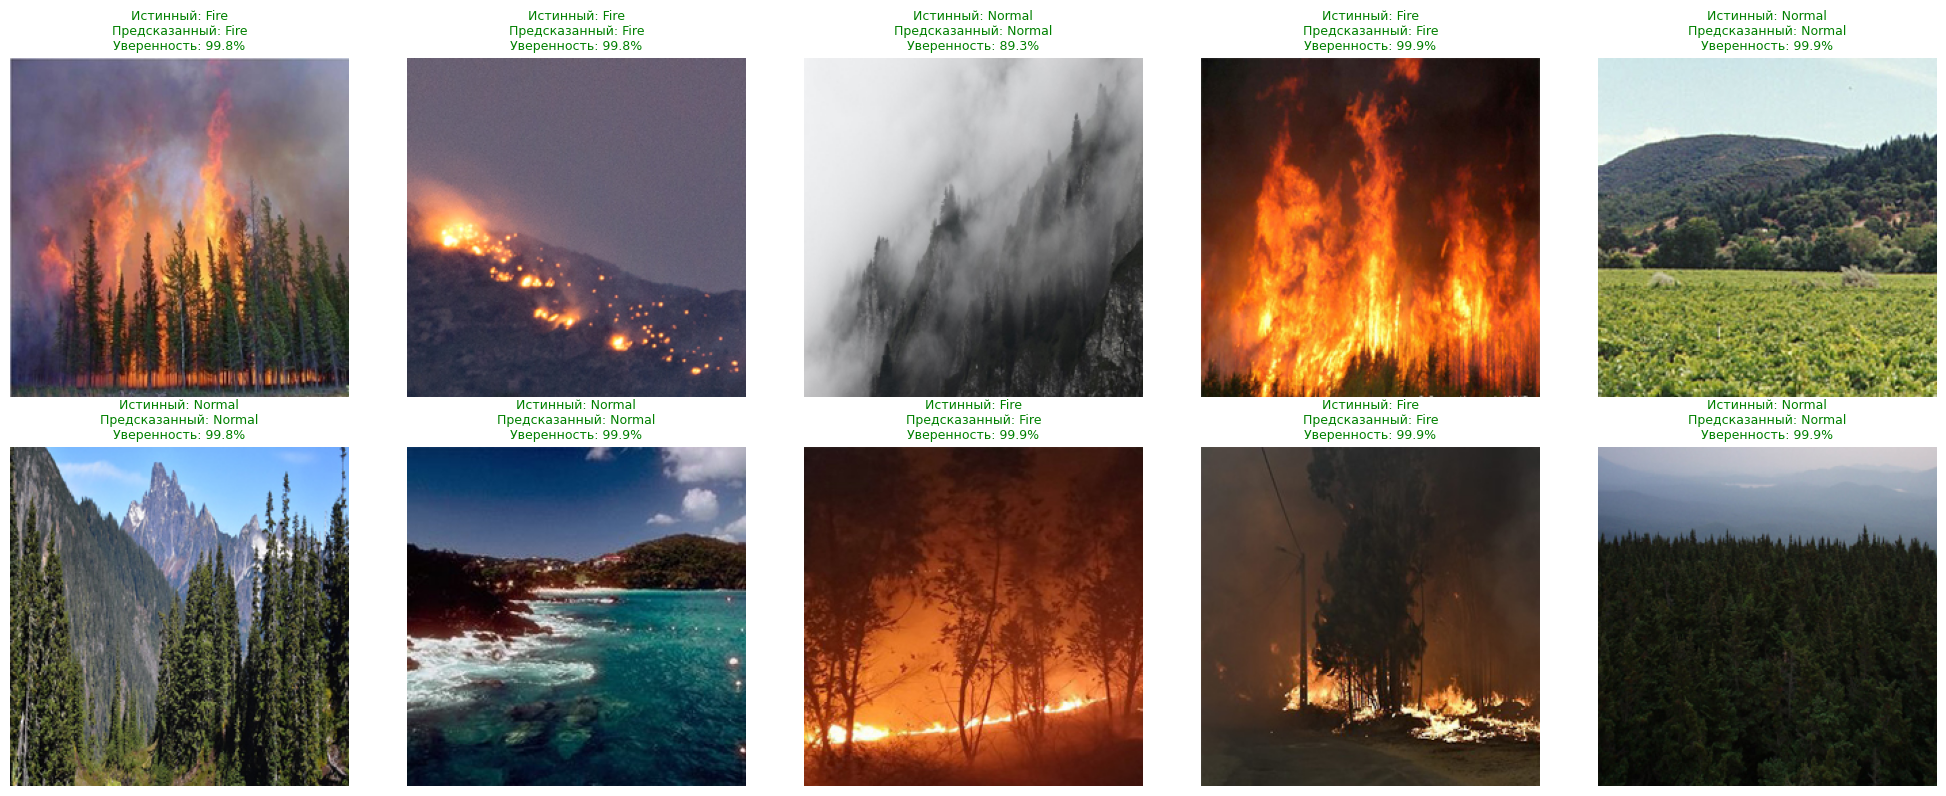


 Результаты демонстрационной выборки:
----------------------------------------------------------------------
       filename true_label predicted_label  confidence  is_correct
  fire_0229.jpg       Fire            Fire    0.998478        True
  fire_0935.jpg       Fire            Fire    0.998236        True
nofire_0400.jpg     Normal          Normal    0.893348        True
  fire_0854.jpg       Fire            Fire    0.998891        True
nofire_0691.jpg     Normal          Normal    0.998843        True
nofire_0842.jpg     Normal          Normal    0.997567        True
nofire_0012.jpg     Normal          Normal    0.998855        True
  fire_0780.jpg       Fire            Fire    0.998825        True
  fire_0702.jpg       Fire            Fire    0.998869        True
nofire_0357.jpg     Normal          Normal    0.998630        True

Точность на демонстрационной выборке: 100.00% (10/10)


In [ ]:
# Сбор всех изображений
train_directory = os.path.join(path, 'Forest Fire Dataset/Training')
test_directory = os.path.join(path, 'Forest Fire Dataset/Testing')

train_images = collect_all_images(train_directory)
test_images = collect_all_images(test_directory)

print(f"Обучающих изображений: {len(train_images)}")
print(f"Тестовых изображений: {len(test_images)}")
print(f"Всего изображений: {len(train_images) + len(test_images)}")

# Демонстрация работы модели
demo_results = demonstrate_model_performance(test_images, processor, model, device)

Функции для полной оценки модели:

1. calculate_classification_metrics() - вычисляет метрики классификации:

    * Основные метрики: accuracy, precision, recall, F1-score

    * Матрицу ошибок (confusion matrix)

    * Детальный отчёт (classification report)

    * Общую статистику выборки

2. evaluate_model() - проводит комплексную оценку модели на тестовом наборе:

    * Определяет истинные метки из имён файлов

    * Выполняет пакетные предсказания для всех изображений

    * Рассчитывает статистику и метрики качества

    * Возвращает DataFrame с результатами и словарь метрик

Функции обеспечивают автоматизированную оценку производительности модели с подробной статистикой.



In [ ]:
def calculate_classification_metrics(true_labels, predicted_labels):
    """
    Вычисляет метрики качества классификации.

    Args:
        true_labels (list): Истинные метки классов
        predicted_labels (list): Предсказанные метки классов

    Returns:
        dict: Словарь с вычисленными метриками
    """
    # Основные метрики
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label='Fire', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, pos_label='Fire', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, pos_label='Fire', zero_division=0)

    # Матрица ошибок
    cm = confusion_matrix(true_labels, predicted_labels, labels=['Fire', 'Normal'])

    # Детальный отчет
    report = classification_report(true_labels, predicted_labels,
                                  target_names=['Fire', 'Normal'], output_dict=True)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': report,
        'total_samples': len(true_labels),
        'correct_predictions': sum(1 for t, p in zip(true_labels, predicted_labels) if t == p)
    }

    return metrics


def evaluate_model(test_images, processor, model, device):
    """
    Проводит полную оценку модели на тестовом наборе данных.

    Args:
        test_images (list): Список путей к тестовым изображениям
        processor: Предобработчик изображений
        model: Модель классификации
        device: Устройство для вычислений

    Returns:
        tuple: (results_df, metrics_dict) - DataFrame с результатами и словарь метрик
    """
    # Определение истинных меток для тестовых изображений
    print("Определение истинных классов для тестовых изображений...")
    true_labels = []
    valid_test_images = []

    for image_path in tqdm(test_images, desc="Считывание файлов"):
        filename = os.path.basename(image_path)
        true_label = extract_class_from_filename(filename)

        if true_label:
            true_labels.append(true_label)
            valid_test_images.append(image_path)

    # Статистика тестового набора
    print(f"Всего тестовых изображений: {len(test_images)}")
    print(f"Изображений с определенным классом: {len(valid_test_images)}")
    print(f"  Класс 'Fire': {true_labels.count('Fire')}")
    print(f"  Класс 'Normal': {true_labels.count('Normal')}")
    print(f"Изображений с неопределенным классом: {len(test_images) - len(valid_test_images)}")

    # Выполнение предсказаний
    predicted_labels = []
    confidence_scores = []

    for image_path in tqdm(valid_test_images, desc="Обработка изображений"):
        prediction = predict_single_image(image_path, processor, model, device)

        if prediction:
            predicted_labels.append(prediction['predicted_label'])
            confidence_scores.append(prediction['confidence'])
        else:
            predicted_labels.append('error')
            confidence_scores.append(0.0)

    # Фильтрация успешно обработанных изображений
    valid_indices = [i for i, pred in enumerate(predicted_labels) if pred != 'error']
    valid_true = [true_labels[i] for i in valid_indices]
    valid_pred = [predicted_labels[i] for i in valid_indices]
    valid_confidences = [confidence_scores[i] for i in valid_indices]

    # Расчет метрик качества
    metrics = calculate_classification_metrics(valid_true, valid_pred)

    # Создание DataFrame с результатами
    results_data = []
    for i in range(len(valid_true)):
        results_data.append({
            'filename': os.path.basename(valid_test_images[valid_indices[i]]),
            'true_label': valid_true[i],
            'predicted_label': valid_pred[i],
            'confidence': valid_confidences[i],
            'is_correct': valid_pred[i] == valid_true[i]
        })

    results_df = pd.DataFrame(results_data)

    return results_df, metrics

In [ ]:
test_results, test_metrics = evaluate_model(all_files, processor, model, device)

Определение истинных классов для тестовых изображений...


Считывание файлов: 100%|██████████| 1900/1900 [00:00<00:00, 743046.86it/s]


Всего тестовых изображений: 1900
Изображений с определенным классом: 1900
  Класс 'Fire': 950
  Класс 'Normal': 950
Изображений с неопределенным классом: 0


Обработка изображений: 100%|██████████| 1900/1900 [00:41<00:00, 45.52it/s]


Функции для визуализации результатов оценки модели:

1. visualize_results() - создаёт комплексные визуализации:

    * Матрицу ошибок (confusion matrix)

    * Распределение уверенности модели для правильных/неправильных предсказаний

    * Примеры ошибок классификации с изображениями

    * Статистику по типам ошибок

2. find_image_path() - вспомогательная функция для поиска полного пути к изображению по имени файла в структуре датасета.

Визуализации помогают проанализировать качество работы модели, понять характер ошибок и распределение уверенности предсказаний.



In [ ]:
def visualize_results(results_df, metrics, data_dir):
    """
    Создает визуализации результатов оценки модели.

    Args:
        results_df (pd.DataFrame): DataFrame с результатами предсказаний
        metrics (dict): Словарь с метриками качества
        data_dir(str): Путь к датасету
    """
    #Матрица ошибок
    print("\n1. Матрица ошибок:")

    cm = metrics['confusion_matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fire', 'Normal'],
                yticklabels=['Fire', 'Normal'])
    plt.title('Матрица ошибок классификации')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

    # Распределение уверенности
    print("\n2. Распределение уверенности предсказаний:")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Разделение по правильности предсказаний
    correct_conf = results_df[results_df['is_correct']]['confidence']
    incorrect_conf = results_df[~results_df['is_correct']]['confidence']

    axes[0].hist(correct_conf, bins=15, alpha=0.7, color='green', label='Правильные', density=True)
    axes[0].hist(incorrect_conf, bins=15, alpha=0.7, color='red', label='Неправильные', density=True)
    axes[0].set_xlabel('Уверенность модели')
    axes[0].set_ylabel('Плотность')
    axes[0].set_title('Распределение уверенности по правильности предсказаний')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Разделение по классам
    fire_conf = results_df[results_df['true_label'] == 'Fire']['confidence']
    nofire_conf = results_df[results_df['true_label'] == 'Normal']['confidence']

    axes[1].hist(fire_conf, bins=15, alpha=0.7, color='orange', label='Класс: Fire', density=True)
    axes[1].hist(nofire_conf, bins=15, alpha=0.7, color='blue', label='Класс: Normal', density=True)
    axes[1].set_xlabel('Уверенность модели')
    axes[1].set_ylabel('Плотность')
    axes[1].set_title('Распределение уверенности по классам')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Примеры ошибок классификации
    print("\n3. Примеры ошибок классификации:")

    error_samples = results_df[~results_df['is_correct']]

    if not error_samples.empty:
        # Выбор до 4 примеров ошибок
        sample_errors = error_samples.head(4)

        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        axes = axes.flatten()

        for idx, (_, row) in enumerate(sample_errors.iterrows()):
            if idx < len(axes):
                # Поиск пути к изображению
                img_filename = row['filename']
                img_path = find_image_path(img_filename, data_dir)

                if img_path and os.path.exists(img_path):
                    image = Image.open(img_path)
                    axes[idx].imshow(image)
                    axes[idx].set_title(
                        f"Истинный: {row['true_label']}\n"
                        f"Предсказанный: {row['predicted_label']}\n"
                        f"Уверенность: {row['confidence']:.1%}",
                        color='red',
                        fontsize=9
                    )
                    axes[idx].axis('off')
                else:
                    axes[idx].text(0.5, 0.5, f"Файл не найден:\n{img_filename}", ha='center', va='center')
                    axes[idx].axis('off')

        # Скрытие неиспользуемых осей
        for idx in range(len(sample_errors), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

        # Статистика по ошибкам
        print(f"Всего ошибок классификации: {len(error_samples)}")
        print("Распределение типов ошибок:")

        error_counts = error_samples.groupby(['true_label', 'predicted_label']).size()
        for (true_lbl, pred_lbl), count in error_counts.items():
            percentage = count / len(error_samples) * 100
            print(f"  {true_lbl} → {pred_lbl}: {count} ({percentage:.1f}%)")
    else:
        print("Ошибок классификации не обнаружено.")


def find_image_path(filename, data_dir):
    """
    Вспомогательная функция для поиска пути к изображению по имени файла.
    """
    data_dir += '/Forest Fire Dataset'
    # Поиск в обучающей выборке
    train_dir = os.path.join(data_dir, 'Training')
    for root, _, files in os.walk(train_dir):
        if filename in files:
            return os.path.join(root, filename)

    # Поиск в тестовой выборке
    test_dir = os.path.join(data_dir, 'Testing')
    for root, _, files in os.walk(test_dir):
        if filename in files:
            return os.path.join(root, filename)

    return None

Результаты оценки модели

Метрики качества:
Точность (Accuracy): 0.9921 (99.21%)
Точность класса 'fire' (Precision): 0.9885 (98.85%)
Полнота класса 'fire' (Recall): 0.9958 (99.58%)
F1-мера (F1-Score): 0.9921 (99.21%)

Статистика:
Всего проанализировано изображений: 1900
Правильных предсказаний: 1885
Неправильных предсказаний: 15

1. Матрица ошибок:


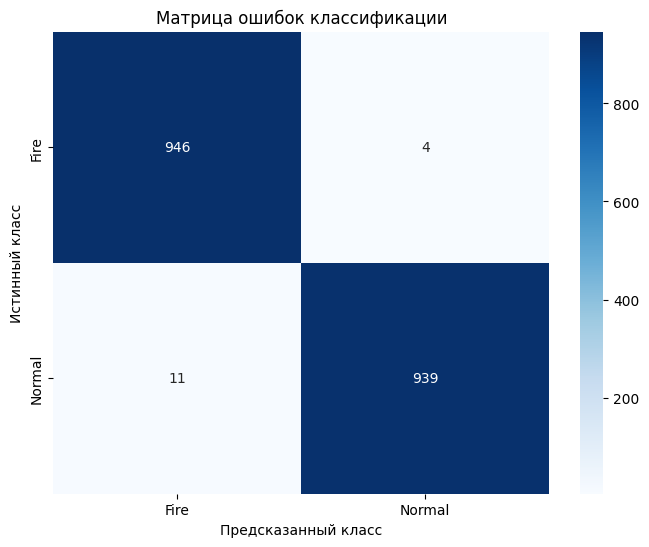


2. Распределение уверенности предсказаний:


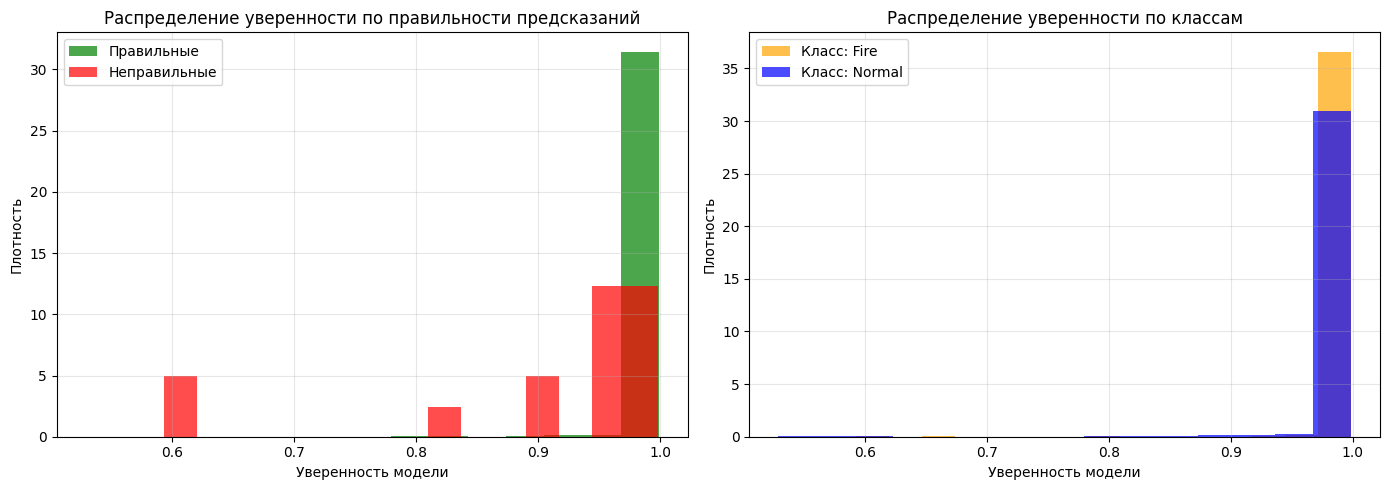


3. Примеры ошибок классификации:


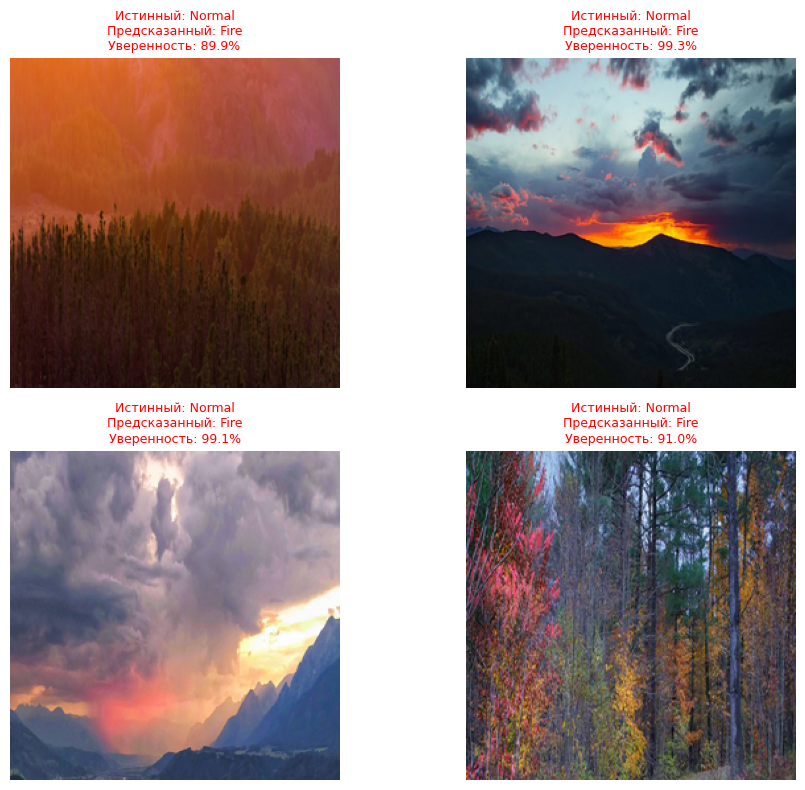

Всего ошибок классификации: 15
Распределение типов ошибок:
  Fire → Normal: 4 (26.7%)
  Normal → Fire: 11 (73.3%)


In [ ]:
# Вывод метрик
print("=" * 80)
print("Результаты оценки модели")
print("=" * 80)

print(f"\nМетрики качества:")
print(f"Точность (Accuracy): {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']:.2%})")
print(f"Точность класса 'fire' (Precision): {test_metrics['precision']:.4f} ({test_metrics['precision']:.2%})")
print(f"Полнота класса 'fire' (Recall): {test_metrics['recall']:.4f} ({test_metrics['recall']:.2%})")
print(f"F1-мера (F1-Score): {test_metrics['f1_score']:.4f} ({test_metrics['f1_score']:.2%})")

print(f"\nСтатистика:")
print(f"Всего проанализировано изображений: {test_metrics['total_samples']}")
print(f"Правильных предсказаний: {test_metrics['correct_predictions']}")
print(f"Неправильных предсказаний: {test_metrics['total_samples'] - test_metrics['correct_predictions']}")

# Визуализация результатов
visualize_results(test_results, test_metrics, path)

Модель **EdBianchi/vit-fire-detection** демонстрирует  высокое качество классификации на тестовом наборе данных. С точностью 99.21% модель идально справляется с задачей обнаружения огня на изображениях.

Ключевые наблюдения:

1. сСбалансированные метрики - одинаково высокие значения precision (98.85%) и recall (99.58%) для класса "Fire" указывают на минимальное количество как ложных срабатываний, так и пропущенных случаев возгорания.

2. Распределение ошибок - из 15 ошибок преобладают ложные срабатывания (Normal -> Fire: 73.3%), что является предпочтительным в системах безопасности, где лучше ложная тревога, чем пропущенное возгорание.

3. Высокая уверенность - модель демонстрирует уверенные предсказания, что подтверждается распределением confidence.

Модель является готовой к применению в реальных системах мониторинга и может служить надежным компонентом для автоматического обнаружения пожаров по изображенияс или видеопотоку. Для производственного использования следует провести дополнительную валидацию на более разнообразных условиях (ночное время, разные погодные условия, различные типы пожаров).

